In [1]:
import pandas, keras
import numpy as np
import os 

from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 5.0)

Using TensorFlow backend.


## Using the right amount of resources

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
set_session(tf.Session(config=config))

# Exploring the dataset:

## Load the dataset files

In [3]:
particles_per_event=40
n_events=10000
features=4

#Load the dataset from storage
store_train = pandas.HDFStore("/disk/lhcb_data/davide/ML4HEP_exercise/train.h5")
df_train = store_train.select("table",stop=n_events)

#Define a list with the desired kinematic variables to access the dataset
cols = [c.format(i) for i in range(particles_per_event) for c in ["E_{0}",  "PX_{0}",  "PY_{0}",  "PZ_{0}"]]

#Extract the train set and the training labels
T = df_train[cols].values[0:n_events].reshape(n_events,particles_per_event,features)
T_labels=df_train["is_signal_new"]

## The dataset tensor
Our dataset is organized in a rank 3 tensor T, whose elements are labeled by indices (i, j, k). Index i runs on the event number, j numbers the particles in each event and index k numbers the variable associated to the track in the event

$$
T = (i=1,...,n_{events}, j=1,...,\textit{particles per event}, k= E_{j} , PX_{j}, PY_{j}, PZ_{j})
$$


In [4]:
T.shape

(10000, 40, 4)

## Fancy indexing

For example, we can access to the single particles four momentum in an event by making use of indexing. Let's take the first particle in the first event: 

In [5]:
print('The first particle in the first event has the following four momentum \n')
print('E_0 = {0:.5g}'.format(T[0,0,0]))
print('PX_0 = {0:.5g}'.format(T[0,0,1]))
print('PY_0 = {0:.5g}'.format(T[0,0,2]))
print('PZ_0 = {0:.5g}'.format(T[0,0,3]))

The first particle in the first event has the following four momentum 

E_0 = 474.07
PX_0 = -250.35
PY_0 = -223.65
PZ_0 = -334.74


The same information can be accessed using numpy fancy indexing syntax, for example

In [6]:
print('The first particle in the first event has the following four momentum \n')
print(T[0,0,:])

The first particle in the first event has the following four momentum 

[ 474.07114 -250.34703 -223.65196 -334.7381 ]


**Exercise**:Now, using numpy array methods calculate:

1) the mean energy of all particles over all events (hint: exclude from the mean the empty events)


2) the mean energy of the first 5 particles for the first 10 events

3) the maximum PZ (in modulus) of the dataset

In [7]:
#Solution:

#1) T[:,:,0][np.where(T[:,:,0]!=0)].mean()
#2) T[0:10,0:5,0].mean()
#3) np.abs(T[:,:,3]).max()

# Variables at hadron colliders: kinematic invariants


The dataset can be cast to the $(E \text{, } \phi \text{, } \eta)$ space.
The rapidity $\eta$ is related to $PZ$ of the particle track. It is defined as:

$$
\eta = \frac{1}{2} ln \left(\frac{E - PZ}{ E + PZ} \right)
$$

While $\phi$ is related to the $(PX, PY)$ components by:

$$
\phi = arctg\left( \frac{PY}{PX} \right)
$$

As shown in figure, the CMS detector is formed by:

1) a cylindrical barrel detector placed around the interaction point that covers a rapidity range of $|\eta| < 2.5 $

2) two $1.48 < | \eta | < 3.0$ endcap regions

<tr>
<td><img src="imgs/front.png" style="width:500px;height:400px;">
<td><img src="imgs/side.png" style="width:500px;height:400px;">
<tr>


<caption><u><font color='purple'>**Figure**</u><font color='purple'>Need a caption here<br> <font color='black'>

## Plotting events

Each event can be displayed as 2D image in the ($\phi, \eta$) coordinates, whose pixels values are the corresponding E recorded by the calorimeter.

First can convert the dataset to this new set of variables. We can do it with a few lines of code thanks to indexing:

In [8]:
eta=np.where(T[:,:,0]==0, 0, 0.5*np.log((T[:,:,0]-T[:,:,3])/(T[:,:,0]+T[:,:,3])));
phi=np.where(T[:,:,0]==0, 0, np.arctan(T[:,:,2]/T[:,:,1]));
E=T[:,:,0];

Then we can check that the $\phi$ angular coverage is of $\pi$

In [9]:
phi_range=np.abs(phi.min())+phi.max()
print(phi_range)

3.141561


And that the rapidity range is within the expected one

In [10]:
eta_range=np.abs(eta.min())+eta.max()
eta.min(), eta.max()

(-2.7575567, 2.7707026)

In order to draw each event we rescale the dataset to be compatible with the image representation

In [11]:
phi_pixels=eta_pixels=40
eta_rescaled=(eta+np.abs(eta.min()))/eta_range*eta_pixels
phi_rescaled=(phi+np.abs(phi.min()))/phi_range*phi_pixels


pic = np.zeros(shape=(phi_pixels,eta_pixels,1),dtype=np.float32)
pics=np.array([pic for j in range(0,n_events)])
    
for event in range(n_events):

    for n_track in range((phi[event]>0).sum()):
        #print(n_track)
        phi_coord = int(np.floor(phi_rescaled[event][n_track]))-1
        eta_coord = int(np.floor(eta_rescaled[event][n_track]))-1
            
        pics[event,phi_coord,eta_coord]=E[event][n_track]

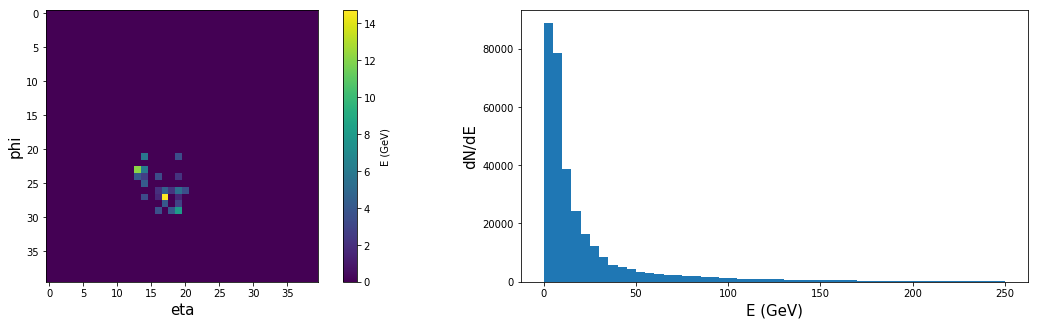

In [12]:
event_display=100
plt.subplot(1,2,1)
plt.imshow(pics[event_display].reshape(40,40))
plt.xlabel('eta', fontsize=15)
plt.ylabel('phi', fontsize=15)
cbar = plt.colorbar()
cbar.set_label('E (GeV)')
plt.subplot(1,2,2)
plt.hist(E[np.where(2<E)],range=(0,250), bins=50);
plt.xlabel('E (GeV)', fontsize=15)
plt.ylabel('dN/dE', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(20,5)

# Building a dense Deep Neural Network

## Adding more layers

Visualising the dataset with images helps to familiarize with the dataset, but in the following example we will use the jet constituents representation. Networks dealing with rank 1 inputs are called dense networks.

We provide you with the syntax that builds a simple feed forward dense Artificial Neural Network, you should make it deep and add 5 layers of 200 nodes each. The syntax for adding one intermediate layer in keras is the following:

```python
model.add(keras.layers.Dense(number_of_nodes, activation_function)
```

(The keras documentation site is a useful resource if you're stuck at any time: https://keras.io/)

***Exercise***:
As an example add 5 layers, each one containing 200 nodes.

***Remember***: this is an example and the number of output nodes per layer can be chosen arbitrarily, usally, a good practice is to reduce the number of output nodes with increasing layer number i.e. layer 1 # of output nodes = 200, layer 2 # of output nodes 100 etc.. 


In [33]:
"""
Syntax that creates the network

"""
#Creates the sequential model
model = keras.models.Sequential() 
nodes=200
number_of_classes=2

#########
model.add(keras.layers.Dense(nodes,                                          # number of output nodes for layer
                             
                             input_shape = (particles_per_event*features,),  # important:
                                                                             # in the first layer you have to 
                                                                             # specify the input shape which
                                                                             # depends on your data
                             
                             activation='tanh'))                             # layer's activation function

model.add(keras.layers.Dense(number_of_classes,                              # number of classes, in our case 2
                                                                             # either signal or background
                             
                             activation='softmax'))                          # activation layer 

#########

"""
Syntax that trains the network

"""
model.compile(loss='categorical_crossentropy', # Loss used for this model
              
              optimizer="Adam",                # Choice of optimizer algorithm
              
              metrics = ["accuracy"])          # a way to measure the performance
                                               # of your network

model_history = model.fit(x=T.reshape(n_events,particles_per_event*features), # train dataset
                          
                          y=keras.utils.to_categorical(T_labels),             # training labels
                          
                          validation_split = 0.1,                             # fraction of the dataset that 
                                                                              # will be used as validation set
                          
                          batch_size=128,                                     # fraction of the dataset that
                                                                              # the network sees in a cycle of 
                                                                              # forward and backward propagation
                          
                          verbose=1,                                          # set the verbosity during training
                                                                              # 0 = silent, 1 = progress bar, 
                                                                              # 2 = one line per epoch.
                          
                          epochs=300)                                         # number of times the network sees 
                                                                              # the entire dataset
 

Train on 9000 samples, validate on 1000 samples
Epoch 1/300
9000/9000 [==============================] - 1s 75us/step - loss: 0.6499 - acc: 0.6423 - val_loss: 0.5986 - val_acc: 0.6740
Epoch 2/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.6092 - acc: 0.6744 - val_loss: 0.5772 - val_acc: 0.7030
Epoch 3/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.5838 - acc: 0.6887 - val_loss: 0.6210 - val_acc: 0.6170
Epoch 4/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5733 - acc: 0.6939 - val_loss: 0.5687 - val_acc: 0.7040
Epoch 5/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.5738 - acc: 0.6948 - val_loss: 0.5783 - val_acc: 0.7050
Epoch 6/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5734 - acc: 0.7000 - val_loss: 0.5860 - val_acc: 0.6870
Epoch 7/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5689 - acc: 0.6990 - val_loss: 0.5720 - val_acc: 0.7140


9000/9000 [==============================] - 0s 26us/step - loss: 0.5109 - acc: 0.7338 - val_loss: 0.5670 - val_acc: 0.7140
Epoch 61/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.5136 - acc: 0.7329 - val_loss: 0.5734 - val_acc: 0.7000
Epoch 62/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5052 - acc: 0.7342 - val_loss: 0.5767 - val_acc: 0.7030
Epoch 63/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5024 - acc: 0.7413 - val_loss: 0.5599 - val_acc: 0.7120
Epoch 64/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.5042 - acc: 0.7401 - val_loss: 0.5725 - val_acc: 0.6930
Epoch 65/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.5044 - acc: 0.7359 - val_loss: 0.5889 - val_acc: 0.6950
Epoch 66/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.4988 - acc: 0.7397 - val_loss: 0.5808 - val_acc: 0.7090
Epoch 67/300
9000/9000 [==============================

Epoch 120/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.4245 - acc: 0.7887 - val_loss: 0.6463 - val_acc: 0.6840
Epoch 121/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.4196 - acc: 0.7911 - val_loss: 0.6607 - val_acc: 0.6820
Epoch 122/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.4057 - acc: 0.8027 - val_loss: 0.6722 - val_acc: 0.6900
Epoch 123/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.4087 - acc: 0.7950 - val_loss: 0.7017 - val_acc: 0.6500
Epoch 124/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.4101 - acc: 0.8003 - val_loss: 0.6551 - val_acc: 0.6680
Epoch 125/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.4055 - acc: 0.8009 - val_loss: 0.6529 - val_acc: 0.6830
Epoch 126/300
9000/9000 [==============================] - 0s 29us/step - loss: 0.3909 - acc: 0.8010 - val_loss: 0.6662 - val_acc: 0.6800
Epoch 127/300
9000/9000 [=========

9000/9000 [==============================] - 0s 28us/step - loss: 0.2884 - acc: 0.8679 - val_loss: 0.8734 - val_acc: 0.6760
Epoch 180/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.2657 - acc: 0.8762 - val_loss: 0.8890 - val_acc: 0.6680
Epoch 181/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.2910 - acc: 0.8648 - val_loss: 0.8873 - val_acc: 0.6770
Epoch 182/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.2808 - acc: 0.8708 - val_loss: 0.8905 - val_acc: 0.6850
Epoch 183/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.2658 - acc: 0.8803 - val_loss: 0.8847 - val_acc: 0.6700
Epoch 184/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.2696 - acc: 0.8791 - val_loss: 0.9011 - val_acc: 0.6840
Epoch 185/300
9000/9000 [==============================] - 0s 28us/step - loss: 0.2546 - acc: 0.8878 - val_loss: 0.8971 - val_acc: 0.6800
Epoch 186/300
9000/9000 [=======================

9000/9000 [==============================] - 0s 26us/step - loss: 0.1707 - acc: 0.9292 - val_loss: 1.1389 - val_acc: 0.6730
Epoch 239/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.1691 - acc: 0.9314 - val_loss: 1.1669 - val_acc: 0.6750
Epoch 240/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.1915 - acc: 0.9184 - val_loss: 1.1194 - val_acc: 0.6700
Epoch 241/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.1830 - acc: 0.9237 - val_loss: 1.1490 - val_acc: 0.6720
Epoch 242/300
9000/9000 [==============================] - 0s 26us/step - loss: 0.1884 - acc: 0.9199 - val_loss: 1.1559 - val_acc: 0.6480
Epoch 243/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.1783 - acc: 0.9244 - val_loss: 1.1697 - val_acc: 0.6740
Epoch 244/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.1687 - acc: 0.9278 - val_loss: 1.1573 - val_acc: 0.6640
Epoch 245/300
9000/9000 [=======================

9000/9000 [==============================] - 0s 27us/step - loss: 0.1783 - acc: 0.9269 - val_loss: 1.2083 - val_acc: 0.6540
Epoch 298/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.1663 - acc: 0.9334 - val_loss: 1.2212 - val_acc: 0.6700
Epoch 299/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.1631 - acc: 0.9358 - val_loss: 1.2121 - val_acc: 0.6590
Epoch 300/300
9000/9000 [==============================] - 0s 27us/step - loss: 0.1544 - acc: 0.9398 - val_loss: 1.2452 - val_acc: 0.6500


The model.fit() method outputs a history object whose keys are

In [34]:
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])



***Exercise***:
Using the train-validation splitting of the train set, show the over-fitting effect of a high capacity network

In [35]:
#Solution
#model.add(keras.layers.Dense(200, input_shape = (particles_per_event*features,), activation='tanh'))
#model.add(keras.layers.Dense(200, activation='tanh'))
#model.add(keras.layers.Dense(200, activation='tanh'))
#model.add(keras.layers.Dense(200, activation='tanh'))
#model.add(keras.layers.Dense(200, activation='tanh'))
#model.add(keras.layers.Dense(2, activation='softmax'))

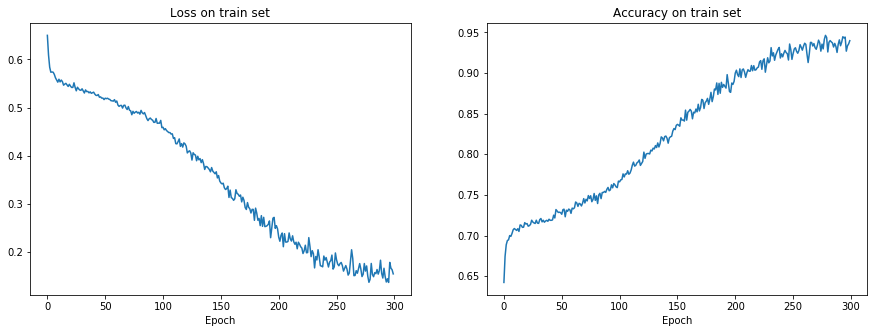

In [36]:
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set')
plt.subplot(1,2,2)
plt.plot(model_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set')
fig = plt.gcf()
fig.set_size_inches(15,5)

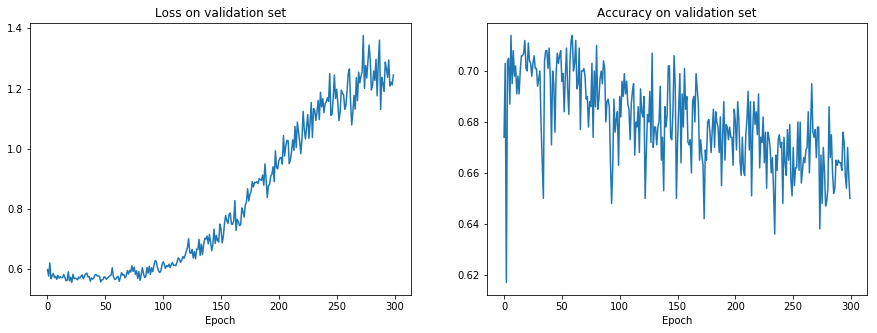

In [37]:
plt.subplot(1,2,1)
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on validation set')
plt.subplot(1,2,2)
plt.plot(model_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on validation set')
fig = plt.gcf()
fig.set_size_inches(15,5)

## 0) Find the optimal network capacity

Deeper network allows to better approximate more complicated problems, but it may lead to overfitting effects for less complicated problems, in other words many layers and many nodes doesn't always mean better performances.

The ***first step*** in building a good network is finding the right architecture, with the right capacity.  
In the next exercise we suggest to create a new network with a ***reduced number of nodes***  and ***reduced number of layers*** with respect to the previous example.

An ***indication*** to estimate the capacity of the network is the total number of trainable parameters, which you can read off by adding 

```python
model.summary()
```

***Exercise***
Find an optimal architecture by reducing the number of nodes and the number of layers. 
Does it help tackling the overfitting problem? 

(hint: we suggest to reduce the number of nodes per layer to 10 and reduce the number of layers to 3 intermediate layers)

In [38]:
"""
Syntax that creates the network

"""
#Creates the sequential model
model = keras.models.Sequential() 
nodes=10
number_of_classes=2

####

#Add layers here

####


"""
Syntax that trains the network

"""
model.compile(loss='categorical_crossentropy', \
              optimizer="Adam", \
              metrics = ["accuracy"]) 

model.summary()
model_history = model.fit(x=T.reshape(n_events,particles_per_event*features), #
                          y=keras.utils.to_categorical(T_labels),             #
                          validation_split = 0.1,                             #
                          batch_size=128,                                     #
                          verbose=0,                                          #
                          epochs=300)                                         #
 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                1610      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 22        
Total params: 1,852
Trainable params: 1,852
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Solution
#model.add(keras.layers.Dense(nodes,  input_shape = (particles_per_event*features,), activation='tanh')) 
#model.add(keras.layers.Dense(nodes, activation='tanh')) 
#model.add(keras.layers.Dense(nodes, activation='tanh')) 
#model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

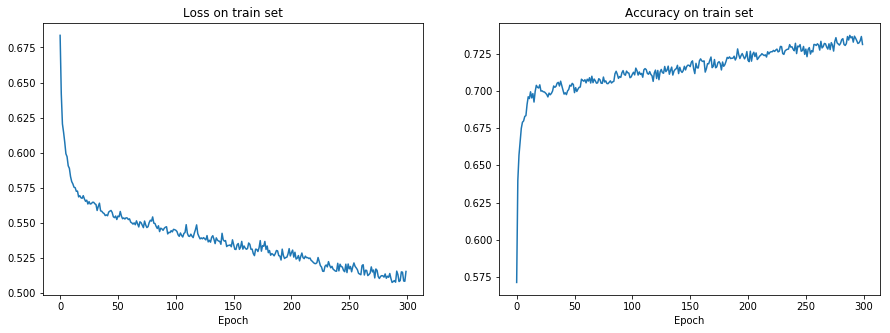

In [40]:
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set')
plt.subplot(1,2,2)
plt.plot(model_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set')
fig = plt.gcf()
fig.set_size_inches(15,5)

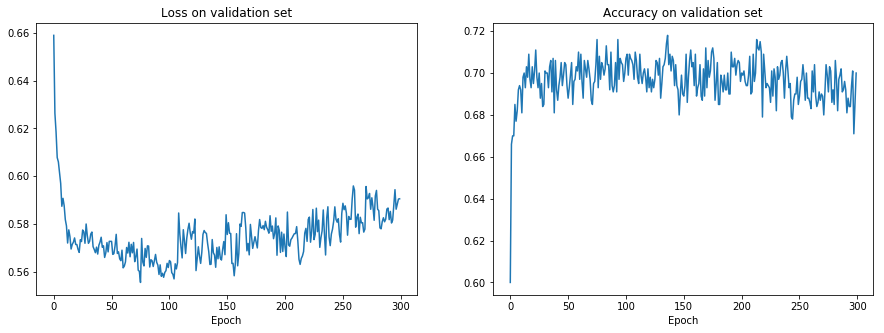

In [41]:
plt.subplot(1,2,1)
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on validation set')
plt.subplot(1,2,2)
plt.plot(model_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on validation set')
fig = plt.gcf()
fig.set_size_inches(15,5)

# Neural network optimization methods

Sometimes though you may need a network with more trainable parameters and, in order to prevent the overfitting tendency of a high capacity network, several regularization methods are available

These methods are of great importance but must not be abused since they introduce an external bias during the training procedure.

## 1) L2 regularization


L2 regularization adds a penalty term for the loss which is proportional to the weights' values (L1) or weights' values squared (L2). This prevents some weights to become numerically dominant with respect to others. It consists of appropriately modifying your cost function, from:

$$
\mathcal{L} = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  \hat{y}^{(i)}\log\left(y^{(i)}\right) + (1-\hat{y}^{(i)})\log\left(1- y^{(i)}\right) \large{)} 
$$
To:
$$\mathcal{L}_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small \hat{y}^{(i)}\log\left(y^{(i)}\right) + (1-\hat{y}^{(i)})\log\left(1- y^{(i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

where $\hat{y}^{(i)}$, ($y^{(i)}$) is the label (network prediction) of the $i$-ith example, $m$ is the total number of examples in the train set and $\lambda$ is the regularization weight. The index $l$ runs on the layer numbers and $W_{k,j}$ are the weight matrices of the network.

In keras, the regularization term are applied on a per-layer basis through the keyword argument

```python
model.add(keras.layers.Dense(output_shape, kernel_regularizer=kernel_regularizer.l2(lambd), bias_regularizer=regularizers.l2(lamb), activation_function)
```

***Exercise*** 
Revert the network architecture to the high capacity case and use it to show the effect of adding L2 regularization on the loss function and on the train/validation accuracies. you can play with the hyperparameter $\lambda$ (called ```lambd``` in code) and see the effect of stronger regularization

In [48]:
from keras import regularizers
"""
Syntax that creates the network

"""
#Creates the sequential model

model_with_reg = keras.models.Sequential() 
lambd=0.01
nodes=200
##################


#Place layers with L2 regularization here


#################

"""
Syntax that trains the network

"""
model_with_reg.compile(loss='categorical_crossentropy', \
              optimizer="Adam", \
              metrics = ["accuracy"]) 

model_with_reg.summary()
model_with_reg_history = model_with_reg.fit(x=T.reshape(n_events,particles_per_event*features), 
                                            y=keras.utils.to_categorical(T_labels), 
                                            validation_split = 0.1, 
                                            batch_size=128, 
                                            verbose=1, 
                                            epochs=50)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 200)               32200     
_________________________________________________________________
dense_55 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_56 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_57 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 402       
Total params: 193,402
Trainable params: 193,402
Non-trainable params: 0
_________________________________________________________________
Trai

In [49]:
#Solution
#model_with_reg.add(keras.layers.Dense(nodes, input_shape = (particles_per_event*features,), activation='tanh'))
#model_with_reg.add(keras.layers.Dense(nodes,  kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l2(lambd), activation='tanh'))
#model_with_reg.add(keras.layers.Dense(nodes,  kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l2(lambd), activation='tanh'))
#model_with_reg.add(keras.layers.Dense(nodes,  kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l2(lambd), activation='tanh'))
#model_with_reg.add(keras.layers.Dense(nodes,  kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l2(lambd), activation='tanh'))
#model_with_reg.add(keras.layers.Dense(2, activation='softmax'))

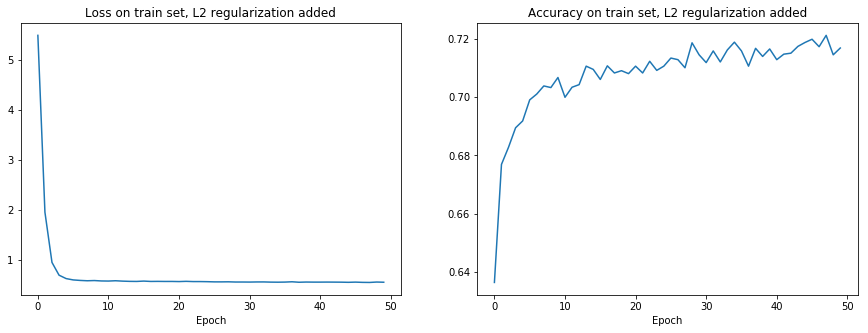

In [52]:
plt.subplot(1,2,1)
plt.plot(model_with_reg_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, L2 regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_reg_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, L2 regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

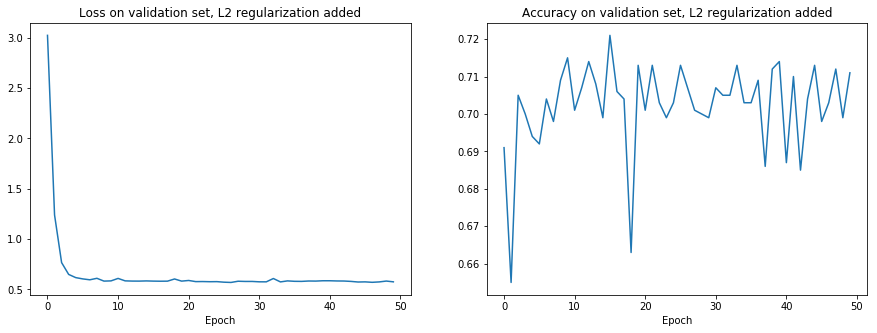

In [53]:
plt.subplot(1,2,1)
plt.plot(model_with_reg_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on validation set, L2 regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_reg_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on validation set, L2 regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

## 2) Dropout regularization

Dropout regularization acts during training, it introduces a non-zero probability of switching some weights' values to zero. By doing this, the network is taught not to rely to heavily on one particular weight and helps preventing overfitting.

Dropout is added right after the layer's definition you intend to apply it to. For example, after the first layer:

```python
model.add(keras.layers.Dense(nodes, input_shape = (particles_per_event*features,), activation='tanh'))
model.add(keras.layers.Dropout(dropout_rate))
```

Note that the ***dropout doesn't add any trainable parameter*** to the network, as you can read directly with the ```model.summary()``` method

***Exercise*** Test dropout regularization on the same network and draw the loss/accuracy plots, play with the ```dropout_rate``` and vary the average fraction of input units set to $0$ during training

In [61]:
"""
Syntax that creates the network

"""
#Creates the sequential model
model_with_drop = keras.models.Sequential() 
dropout_rate=0.1
nodes=200
##################


#Place layers with dropout regularization here


#################

"""
Syntax that trains the network

"""
model_with_drop.compile(loss='categorical_crossentropy', 
              optimizer="Adam", 
              metrics = ["accuracy"]) 

model_with_drop.summary()
model_with_drop_history = model_with_drop.fit(x=T.reshape(n_events,particles_per_event*features), 
                                            y=keras.utils.to_categorical(T_labels), 
                                            validation_split = 0.1, 
                                            batch_size=128, 
                                            verbose=1, 
                                            epochs=50)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 200)               32200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 200)               40200     
__________

Epoch 48/80
9000/9000 [==============================] - 0s 34us/step - loss: 0.5443 - acc: 0.7120 - val_loss: 0.5599 - val_acc: 0.7190
Epoch 49/80
9000/9000 [==============================] - 0s 33us/step - loss: 0.5474 - acc: 0.7076 - val_loss: 0.5598 - val_acc: 0.7220
Epoch 50/80
9000/9000 [==============================] - 0s 33us/step - loss: 0.5503 - acc: 0.7064 - val_loss: 0.5613 - val_acc: 0.7120
Epoch 51/80
9000/9000 [==============================] - 0s 34us/step - loss: 0.5435 - acc: 0.7108 - val_loss: 0.5591 - val_acc: 0.7140
Epoch 52/80
9000/9000 [==============================] - 0s 34us/step - loss: 0.5410 - acc: 0.7084 - val_loss: 0.5589 - val_acc: 0.7100
Epoch 53/80
9000/9000 [==============================] - 0s 33us/step - loss: 0.5418 - acc: 0.7094 - val_loss: 0.5562 - val_acc: 0.7090
Epoch 54/80
9000/9000 [==============================] - 0s 33us/step - loss: 0.5429 - acc: 0.7109 - val_loss: 0.5568 - val_acc: 0.7160
Epoch 55/80
9000/9000 [=========================

In [65]:
#Solution
#model_with_drop.add(keras.layers.Dense(nodes, input_shape = (particles_per_event*features,), activation='tanh'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate))
#model_with_drop.add(keras.layers.Dense(nodes, activation='tanh'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate))
#model_with_drop.add(keras.layers.Dense(nodes, activation='tanh'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate))
#model_with_drop.add(keras.layers.Dense(nodes, activation='tanh'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate))
#model_with_drop.add(keras.layers.Dense(nodes, activation='tanh'))
#model_with_drop.add(keras.layers.Dropout(dropout_rate))
#model_with_drop.add(keras.layers.Dense(2, activation='softmax'))

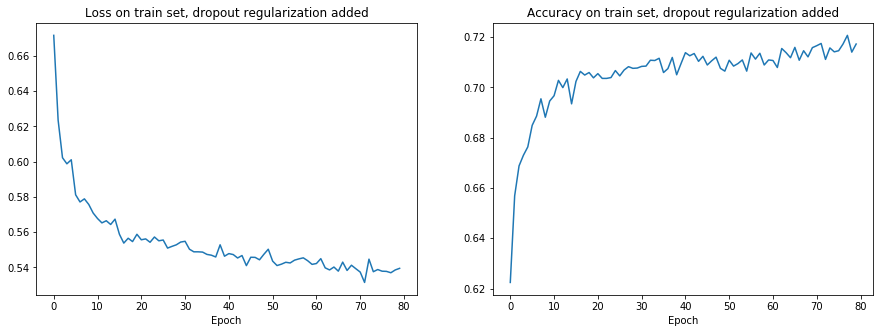

In [66]:
plt.subplot(1,2,1)
plt.plot(model_with_drop_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_drop_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

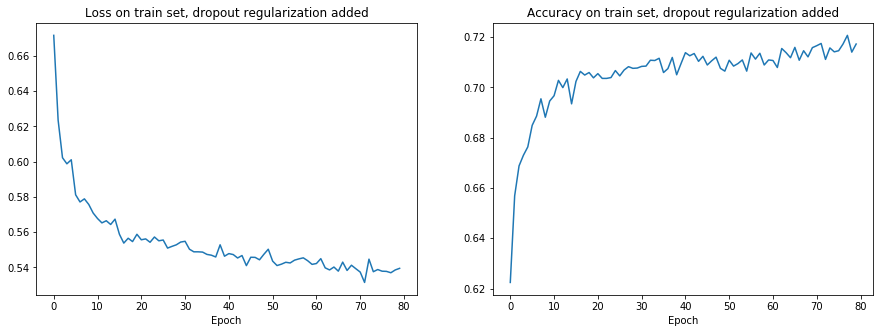

In [67]:
plt.subplot(1,2,1)
plt.plot(model_with_drop_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization added')
plt.subplot(1,2,2)
plt.plot(model_with_drop_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization added')
fig = plt.gcf()
fig.set_size_inches(15,5)

## 3) Adding batch-normalization

Batch-normalization (BN) is a useful tool in training since it stabilizes the training process by normalising the weights at each batch to null mean and unit standard deviation. 

BN is applied to layers singularly and it is generally used to normalise the input to the activation function. It makes the weights of deep layers of the neural network more robust to change in weights of the first layers. By reducing the coupling between layers it causes each layer to learn more independently from the others and has a net effect of speeding up the learning process.

As an example it is implemented for the first layer in the following way

```python
model.add(keras.layers.Dense(nodes, input_shape = (particles_per_event*features,))
model.add(BatchNormalization())
model.add(Activation('tanh'))
```
In addition we can add a dropout probability with the line:

```python
model.add(keras.layers.Dropout(dropout_rate))
```

***Exercise*** The following neural network puts together all the techniques shown in the previous examples, feel free to edit and play with it to see the effect on the training process



In [13]:
from keras import regularizers

"""
Syntax that creates the network

"""
#Creates the sequential model
model_with_bn = keras.models.Sequential() 
dropout_rate=0.1
lambd=0.08
nodes=100
##################


model_with_bn.add(keras.layers.Dense(nodes*2, input_shape = (particles_per_event*features,)))
model_with_bn.add(keras.layers.normalization.BatchNormalization())
model_with_bn.add(keras.layers.LeakyReLU(0.1))
model_with_bn.add(keras.layers.Dropout(dropout_rate))

model_with_bn.add(keras.layers.Dense(nodes, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd),))
model_with_bn.add(keras.layers.normalization.BatchNormalization())
model_with_bn.add(keras.layers.LeakyReLU(0.1))
model_with_bn.add(keras.layers.Dropout(dropout_rate))

model_with_bn.add(keras.layers.Dense(nodes//2, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd),))
model_with_bn.add(keras.layers.normalization.BatchNormalization()) 
model_with_bn.add(keras.layers.LeakyReLU(0.1))
model_with_bn.add(keras.layers.Dropout(dropout_rate))

model_with_bn.add(keras.layers.Dense(nodes//4, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd),))
model_with_bn.add(keras.layers.normalization.BatchNormalization()) 
model_with_bn.add(keras.layers.LeakyReLU(0.1))
model_with_bn.add(keras.layers.Dropout(dropout_rate))

model_with_bn.add(keras.layers.Dense(nodes//10, kernel_regularizer=regularizers.l2(lambd), bias_regularizer=regularizers.l1(lambd),))
model_with_bn.add(keras.layers.normalization.BatchNormalization()) 
model_with_bn.add(keras.layers.LeakyReLU(0.1))
model_with_bn.add(keras.layers.Dropout(dropout_rate))

model_with_bn.add(keras.layers.Dense(2, activation='softmax'))


#################

"""
Syntax that trains the network

"""
model_with_bn.compile(loss='categorical_crossentropy', 
              optimizer="Adam", 
              metrics = ["accuracy"]) 

model_with_bn.summary()
model_with_bn_history = model_with_bn.fit(x=T.reshape(n_events,particles_per_event*features), 
                                            y=keras.utils.to_categorical(T_labels), 
                                            validation_split = 0.1, 
                                            batch_size=256, 
                                            verbose=1, 
                                            epochs=200)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               32200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)               0         
__________

Epoch 38/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5810 - acc: 0.7106 - val_loss: 0.6169 - val_acc: 0.7080
Epoch 39/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.5721 - acc: 0.7148 - val_loss: 0.6499 - val_acc: 0.6460
Epoch 40/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5802 - acc: 0.7129 - val_loss: 0.5781 - val_acc: 0.7230
Epoch 41/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5714 - acc: 0.7154 - val_loss: 0.5698 - val_acc: 0.7320
Epoch 42/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5686 - acc: 0.7189 - val_loss: 0.5833 - val_acc: 0.7060
Epoch 43/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5786 - acc: 0.7149 - val_loss: 0.6023 - val_acc: 0.7040
Epoch 44/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.5658 - acc: 0.7236 - val_loss: 0.5891 - val_acc: 0.7400
Epoch 45/200
9000/9000 [=================

Epoch 98/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.4690 - acc: 0.7988 - val_loss: 0.5130 - val_acc: 0.7760
Epoch 99/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.4551 - acc: 0.8069 - val_loss: 0.5058 - val_acc: 0.7720
Epoch 100/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.4597 - acc: 0.8023 - val_loss: 0.5141 - val_acc: 0.7700
Epoch 101/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.4528 - acc: 0.8044 - val_loss: 0.5268 - val_acc: 0.7650
Epoch 102/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.4444 - acc: 0.8112 - val_loss: 0.5239 - val_acc: 0.7750
Epoch 103/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.4442 - acc: 0.8109 - val_loss: 0.5000 - val_acc: 0.7700
Epoch 104/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.4400 - acc: 0.8130 - val_loss: 0.5411 - val_acc: 0.7610
Epoch 105/200
9000/9000 [===========

9000/9000 [==============================] - 0s 41us/step - loss: 0.3915 - acc: 0.8406 - val_loss: 0.5689 - val_acc: 0.7590
Epoch 158/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.3879 - acc: 0.8488 - val_loss: 0.5863 - val_acc: 0.7420
Epoch 159/200
9000/9000 [==============================] - 0s 39us/step - loss: 0.3770 - acc: 0.8530 - val_loss: 0.5199 - val_acc: 0.7760
Epoch 160/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.3781 - acc: 0.8511 - val_loss: 0.5075 - val_acc: 0.7660
Epoch 161/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.3718 - acc: 0.8526 - val_loss: 0.4945 - val_acc: 0.7900
Epoch 162/200
9000/9000 [==============================] - 0s 41us/step - loss: 0.3723 - acc: 0.8532 - val_loss: 0.5251 - val_acc: 0.7980
Epoch 163/200
9000/9000 [==============================] - 0s 40us/step - loss: 0.3795 - acc: 0.8524 - val_loss: 0.5490 - val_acc: 0.7820
Epoch 164/200
9000/9000 [=======================

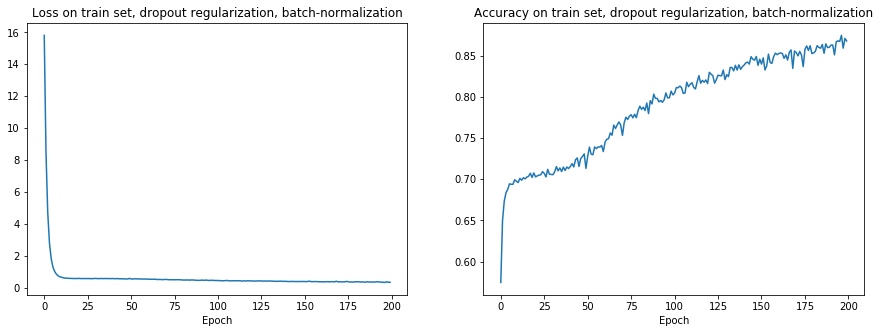

In [14]:
plt.subplot(1,2,1)
plt.plot(model_with_bn_history.history['loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization, batch-normalization')
plt.subplot(1,2,2)
plt.plot(model_with_bn_history.history['acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization, batch-normalization')
fig = plt.gcf()
fig.set_size_inches(15,5)

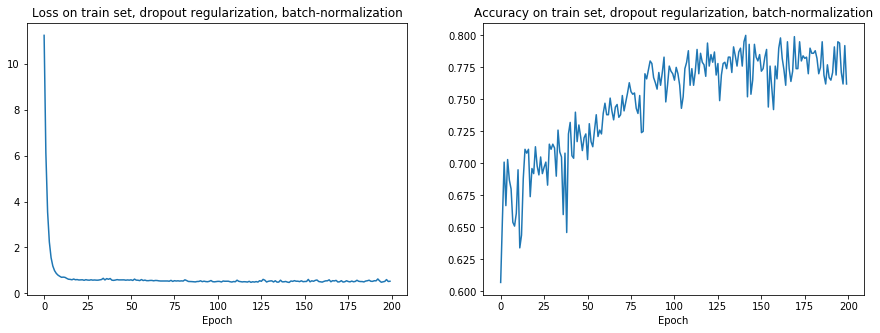

In [15]:
plt.subplot(1,2,1)
plt.plot(model_with_bn_history.history['val_loss'])
plt.xlabel('Epoch')
plt.title('Loss on train set, dropout regularization, batch-normalization')
plt.subplot(1,2,2)
plt.plot(model_with_bn_history.history['val_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy on train set, dropout regularization, batch-normalization')
fig = plt.gcf()
fig.set_size_inches(15,5)

# Evaluating the network performance: ROC/AUC curves

In [16]:
### Evaluate performance on independent sample
# Prepare input
store_test = pandas.HDFStore("/disk/lhcb_data/davide/ML4HEP_exercise/test.h5")
df_test = store_test.select("table")

test_size=2000


T_test=df_test[cols].values[0:test_size].reshape(test_size,particles_per_event,features)
T_test_labels=keras.utils.to_categorical(df_test["is_signal_new"])[0:test_size]

# Run DNN

print("Running on full test sample for each model trained. This may take a moment.")
predictions_bn = model_with_bn.predict(T_test.reshape(test_size, particles_per_event*features))

#Add ROC/AUC test

Running on full test sample for each model trained. This may take a moment.


In [17]:
predictions_bn.shape

(2000, 2)

In [18]:
T_test_labels.shape

(2000, 2)

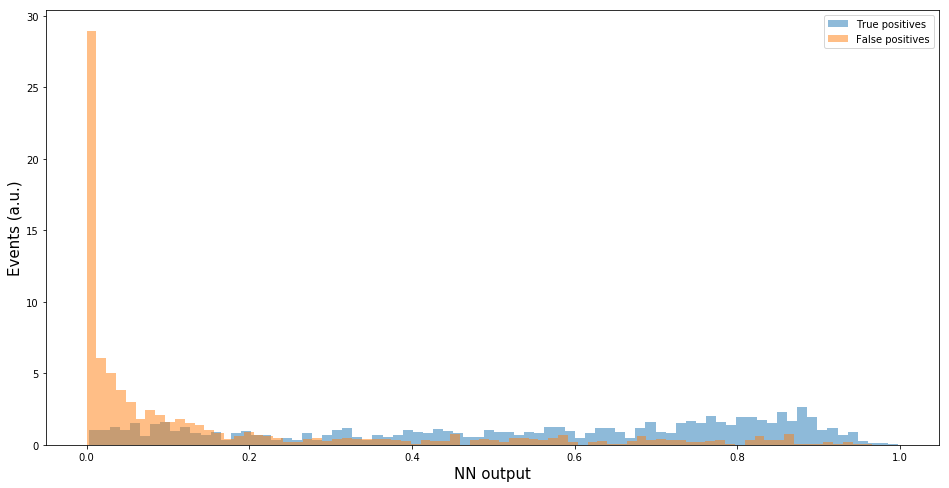

In [19]:
true_positives = predictions_bn[:,1][np.where(T_test_labels[:,1]==1)]
false_positives = predictions_bn[:,1][np.where(T_test_labels[:,0]==1)]

plt.hist(true_positives,alpha=0.5,bins=80,density=True,label="True positives");
plt.hist(false_positives,alpha=0.5,bins=80,density=True, label="False positives");
plt.legend()
plt.xlabel("NN output", fontsize='15')
plt.ylabel("Events (a.u.)", fontsize='15')
fig=plt.gcf()
fig.set_size_inches(16,8)

pAUC from NN 0.8545326900921659


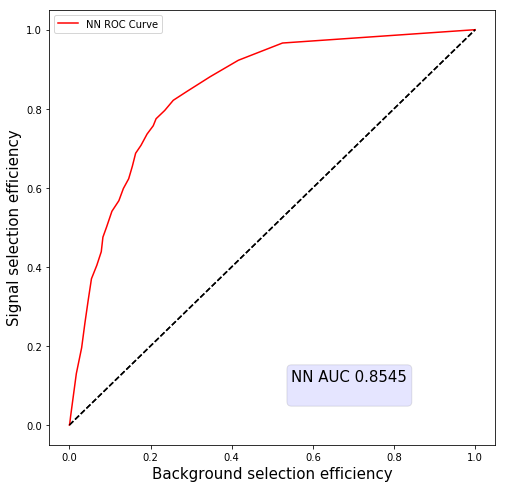

In [20]:
threshold_range=np.linspace(0.0,1.,num=30)

sig_eps_vals=[sel_eff(true_positives,threshold_range[i]) for i in range(len(threshold_range))]
bkg_eps_vals=[sel_eff(false_positives,threshold_range[i]) for i in range(len(threshold_range))]

plt.plot(threshold_range,threshold_range, 'black', linestyle='dashed')
plt.plot(bkg_eps_vals,sig_eps_vals, 'r', label="NN ROC Curve")
pAUC_NN=roc_auc_score(T_test_labels,predictions_bn)
print("pAUC from NN {0}".format(pAUC_NN))

plt.plot(threshold_range,threshold_range, 'black', linestyle='dashed')

plt.xlabel("Background rejection efficiency", fontsize='15')
plt.ylabel("Signal selection efficiency", fontsize='15')

plt.text(0.69,0.1,"NN AUC {0:.4g}\n".format(pAUC_NN), bbox=dict(boxstyle="round", facecolor='blue', alpha=0.10), horizontalalignment='center', verticalalignment='center',fontsize='15')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(8,8)
